In [1]:
import csv
import pandas as pd  
import numpy as np
import re
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt 
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report



import warnings

from sklearn.tree import DecisionTreeClassifier
warnings.filterwarnings("ignore") 

# 1. Reading CSV Files
#### Read all 4 files.

In [2]:
#1)Read CSV File: OPEL
df_opel = pd.read_csv('data/opel_corsa_01.csv', sep=";")
df_opel = df_opel.rename(columns = {'drivingStyle,,,,,,,,,,': 'drivingStyle'})
df_opel_2 = pd.read_csv('data/opel_corsa_02.csv', sep=";")
df_peugeot = pd.read_csv('data/peugeot_207_01.csv', sep=";")
df_peugeot_2 = pd.read_csv('data/peugeot_207_02.csv', sep=";")

# 2. Sanitization
    1) Adding spaces and capitalization to the headers.
    2) Removing unwanted strings from labels & Ading capitalization and spaces.
    3) Replacing features decimal commas with decimal points.
    4) Remove NaN's

### 2.1 Concatenate and shuffle the data 

In [3]:
df = shuffle(pd.concat([df_peugeot,df_peugeot_2,df_opel,df_opel_2]))

### 2.2 Adding spaces for column headers

In [4]:
for col in df.columns:
    newFormat = re.sub(r"(\w)([A-Z])", r"\1 \2", col).capitalize()
    df.rename(columns={col:newFormat},inplace=True)


#Creating a selection of columns to make edits
col_label = ['Road surface', 'Traffic','Driving style']
col_feat = list(df.columns[:14])

### 2.3 Removing unwanted strings from labels & Ading capitalization and spaces.

In [5]:
#Adding space between capital letters
df[col_label] = df[col_label].replace(r"([A-Z])", r" \1", regex=True)
df[col_label] = df[col_label].replace(',', '', regex=True)

### 2.4  Replacing features decimal commas with decimal points.

In [6]:
#Replacing commas with . 
df[col_feat] = df[col_feat].replace(',', '.', regex=True)

### 2.5 Reviewing NaN Values

In [7]:
print('Number of NaN in df     : ', sum(df.isnull().sum()),'\n\n')

print('Number of NaN by column: \n\n',df.isnull().sum())

Number of NaN in df     :  3093 


Number of NaN by column: 

 Altitude variation              180
Vehicle speed instantaneous      44
Vehicle speed average          1182
Vehicle speed variance         1182
Vehicle speed variation         188
Longitudinal acceleration         0
Engine load                       5
Engine coolant temperature        5
Manifold absolute pressure        5
Engine rp m                       5
Mass air flow                     5
Intake air temperature            5
Vertical acceleration             0
Fuel consumption average        286
Road surface                      0
Traffic                           0
Driving style                     1
dtype: int64


### 2.6 Drop NaN values

In [8]:
df = df.dropna()
print('number of NaN values: ',df.isnull().sum())

number of NaN values:  Altitude variation             0
Vehicle speed instantaneous    0
Vehicle speed average          0
Vehicle speed variance         0
Vehicle speed variation        0
Longitudinal acceleration      0
Engine load                    0
Engine coolant temperature     0
Manifold absolute pressure     0
Engine rp m                    0
Mass air flow                  0
Intake air temperature         0
Vertical acceleration          0
Fuel consumption average       0
Road surface                   0
Traffic                        0
Driving style                  0
dtype: int64


# 3. Preparing dataset for modeling

## 3.1 Converting features into numeric values

In [9]:
print('Before:\n\n ',df.dtypes,'\n\n\n')

#Changing DataTypes to numeric
for i in df.columns:
    try:
        df[i] = pd.to_numeric(df[i])
    except:
        pass
    
print('After:\n\n ',df.dtypes)

Before:

  Altitude variation              object
Vehicle speed instantaneous     object
Vehicle speed average           object
Vehicle speed variance          object
Vehicle speed variation         object
Longitudinal acceleration       object
Engine load                     object
Engine coolant temperature     float64
Manifold absolute pressure     float64
Engine rp m                     object
Mass air flow                   object
Intake air temperature          object
Vertical acceleration           object
Fuel consumption average        object
Road surface                    object
Traffic                         object
Driving style                   object
dtype: object 



After:

  Altitude variation             float64
Vehicle speed instantaneous    float64
Vehicle speed average          float64
Vehicle speed variance         float64
Vehicle speed variation        float64
Longitudinal acceleration      float64
Engine load                    float64
Engine coolant temperatur

## 3.2 Resizing the data to match the class with least number of rows as to get an equal sample for each class

In [10]:
df.groupby('Driving style').size()
df = df.groupby('Driving style')
df = df.apply(lambda x: x.sample(df.size().min())).reset_index(drop=True)

df.groupby('Driving style').size()

Driving style
 Aggressive Style    2759
 Even Pace Style     2759
dtype: int64

## 3.3 Handling Outliers

We can use the skew() function to find the measure of asymmetry of the probability distribution in data over the index axis. Which should be between -1 and +1.

#### We can represent this numerically as follows:


In [11]:
print(df.skew())

Altitude variation             0.067753
Vehicle speed instantaneous    1.113961
Vehicle speed average          1.300442
Vehicle speed variance         1.861563
Vehicle speed variation       -0.662070
Longitudinal acceleration      2.275080
Engine load                    0.571546
Engine coolant temperature    -1.675501
Manifold absolute pressure     2.446621
Engine rp m                    0.191326
Mass air flow                  1.073196
Intake air temperature         1.239381
Vertical acceleration          3.667878
Fuel consumption average       0.498485
dtype: float64


#### Visual representation using boxplot below:

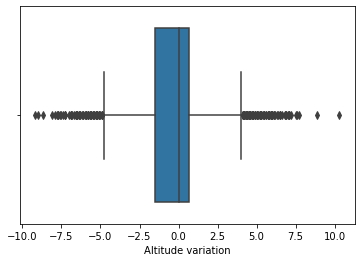

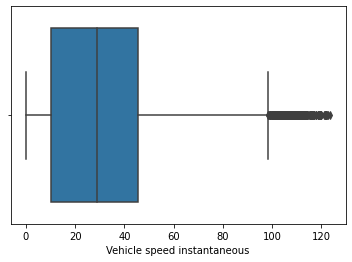

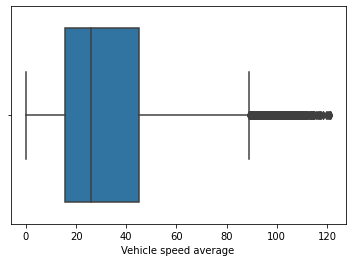

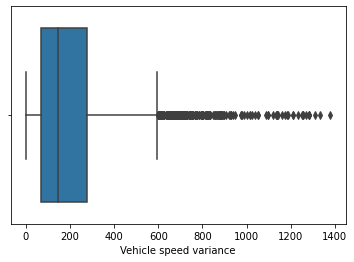

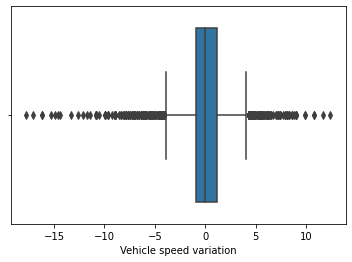

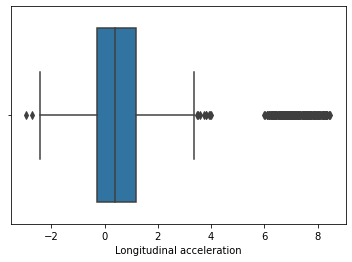

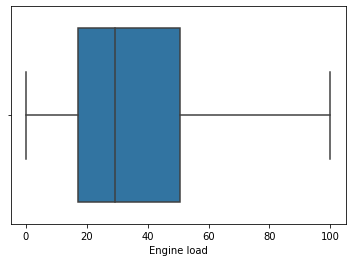

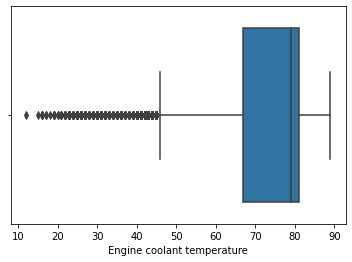

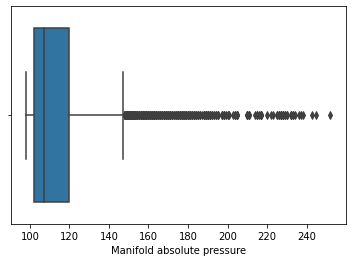

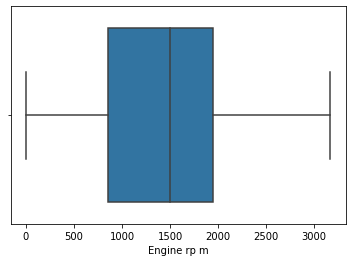

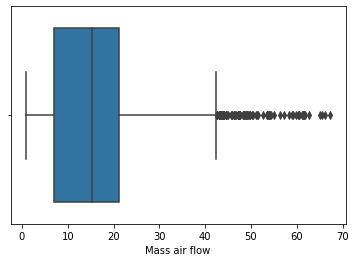

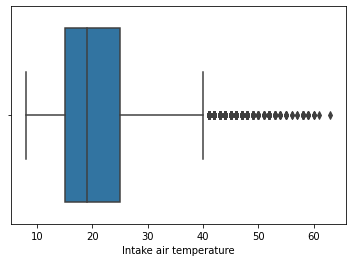

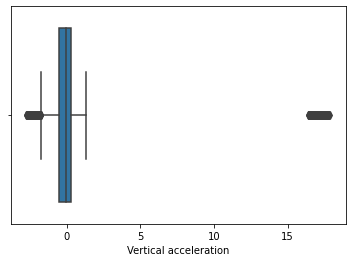

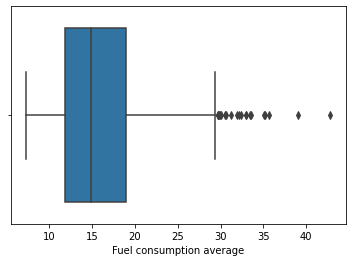

In [12]:
# Plotting Boxplots for checking outliers
        
for i in df.select_dtypes(exclude='object'):
    sn.boxplot(df[i])
    plt.show()

#### Clearly we have outliers as shown from above box plots & and distribution shown from the skew function

Reference on how i handled outliers: https://www.pluralsight.com/guides/cleaning-up-data-from-outliers

Detecting and removing outliers:

In [13]:
# handling the outliers
def detect_outliers(df,variable):
    
    first_quantile = df[variable].quantile(0.25)
    third_quantile = df[variable].quantile(0.75)
    iqr = third_quantile - first_quantile
    lower_bound = (first_quantile - 1.5*iqr)
    upper_bound = (third_quantile + 1.5*iqr)
    
    high_outliers = df[variable]>upper_bound
    low_outliers = df[variable] < lower_bound
    return df[(low_outliers)|(high_outliers)]

#  removing outliers
def handle_outliers(df,variable):

    IQR = df[variable].quantile(0.75)-df[variable].quantile(0.25)
    upper_bridge = df[variable].quantile(0.75)+(IQR*1.5)
    low_bridge = df[variable].quantile(0.25)-(IQR*1.5)

    df.loc[df[variable]>=upper_bridge, variable]=upper_bridge
    df.loc[df[variable]<=low_bridge, variable]=abs(low_bridge)
    
# columns having outliers in survive 
outliers_columns = []
for i in df.select_dtypes(exclude='object').columns:
    if detect_outliers(df,i).shape[0]>1:
        outliers_columns.append(i)

#Handling Outliers in survive 
for feat in outliers_columns:
    handle_outliers(df,feat)


### Numerical representation of distribution after handling the outliers.

In [14]:
print(df.skew())

Altitude variation             0.229012
Vehicle speed instantaneous    0.913569
Vehicle speed average          1.015752
Vehicle speed variance         1.033084
Vehicle speed variation        0.232394
Longitudinal acceleration      0.610642
Engine load                    0.571546
Engine coolant temperature    -1.247192
Manifold absolute pressure     1.183386
Engine rp m                    0.191326
Mass air flow                  0.734889
Intake air temperature         0.872693
Vertical acceleration          0.348703
Fuel consumption average       0.411997
dtype: float64


### Visual reppresentation of distribution after handling the outliers.

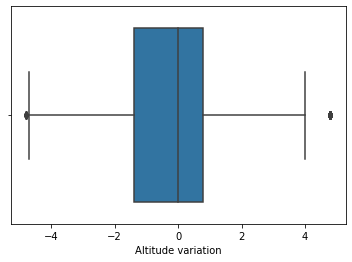

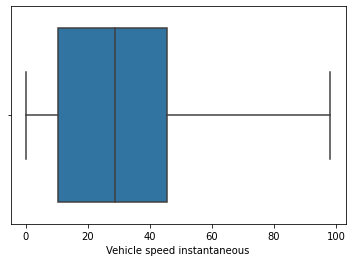

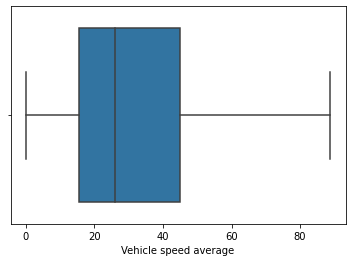

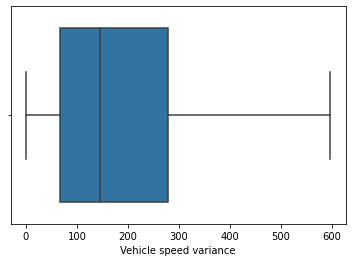

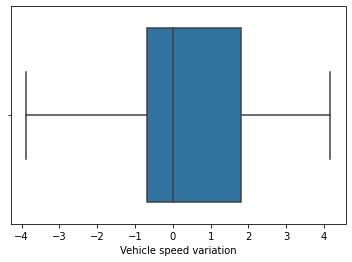

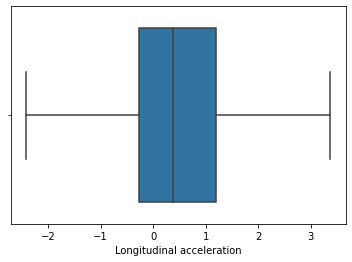

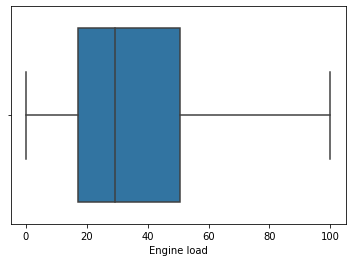

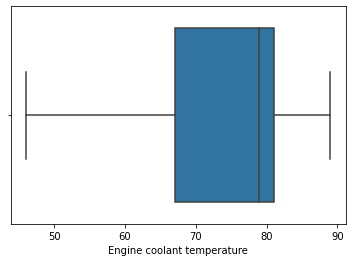

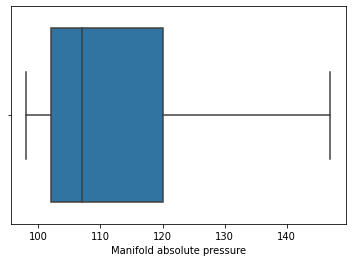

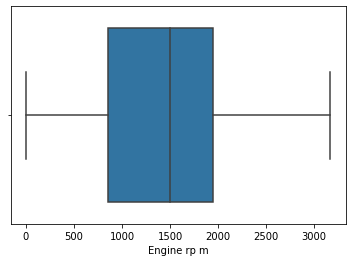

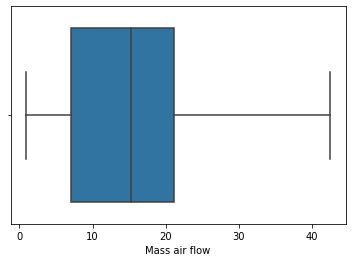

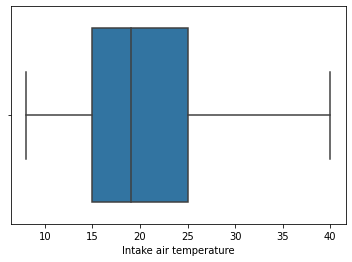

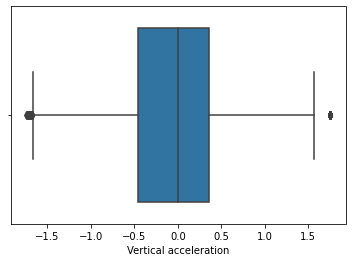

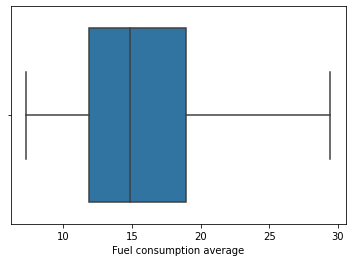

In [15]:
for i in df.select_dtypes(exclude='object'):
    sn.boxplot(df[i])
    plt.show()

## 3.4 Encode the target Output Column using oneHot

In [16]:
# Encoding target columns using oneHot
target_columns = ['Driving style']
drop_columns = ["Traffic", "Road surface"]
df.drop(drop_columns, axis = 1,inplace=True)

#Getting one-hot encoding for the classes in the labelled outputs
one_hot = pd.get_dummies(df[target_columns])


#Dropping the target columns 
df.drop(target_columns, axis = 1,inplace=True)

df['Target'] = one_hot.values.tolist() 



## 3.5 Splitting data into train/test

In [17]:
# Shuffing Dataset / frac=1 is to shuffle 100% of dataset, if for ex 0.5 then 50%
df = df.sample(frac=1)
# Splitting in to X,y
X = df.drop(['Target'], axis=1)


y = np.array(df['Target'].values.tolist())

#Splitting in to train and test.  The test split is 20% and the training split is 80%. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print('X-Train Shape:',X_train.shape,'\n','X-Test Shape:', X_test.shape,'\n','Y-Train Shape:', y_train.shape,'\n', 'Y-Test Shape:',y_test.shape)

df

X-Train Shape: (4414, 14) 
 X-Test Shape: (1104, 14) 
 Y-Train Shape: (4414, 2) 
 Y-Test Shape: (1104, 2)


,Altitude variation,Vehicle speed instantaneous,Vehicle speed average,Vehicle speed variance,Vehicle speed variation,Longitudinal acceleration,Engine load,Engine coolant temperature,Manifold absolute pressure,Engine rp m,Mass air flow,Intake air temperature,Vertical acceleration,Fuel consumption average,Target
916,-0.899994,45.899998,52.859998,597.171318,0.899998,0.819500,0.000000,78.0,114.0,1125.5,22.549999,40.0,-0.839500,7.996965,"[1, 0]"
5414,0.000000,0.000000,7.160724,119.586826,0.000000,-0.441400,56.470589,79.0,105.0,1166.0,13.260000,12.0,0.472600,16.221504,"[0, 1]"
135,0.799988,5.404320,42.082388,143.041009,1.576261,0.402000,46.666668,53.0,100.0,1466.0,18.299999,18.0,0.007800,15.894388,"[1, 0]"
2821,-1.300003,48.599998,36.314999,182.725692,-1.799999,1.823300,0.000000,46.0,104.0,1404.5,17.690001,16.0,-0.735300,16.854078,"[0, 1]"
2242,0.900024,4.053240,22.521752,51.617863,3.938854,0.902000,24.705883,73.0,98.0,828.0,5.360000,24.0,-0.742000,21.955652,"[1, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975,0.200012,8.556840,7.678638,43.893718,-3.828059,3.375087,31.372549,65.0,101.0,867.0,5.330000,15.0,1.564213,20.577492,"[1, 0]"
1454,-2.800003,60.798599,67.242499,247.062273,-1.576263,-0.039200,68.235298,83.0,147.0,1967.0,31.809999,19.0,-0.050800,12.475195,"[1, 0]"
3279,-2.600037,64.401474,88.828996,230.079052,2.026611,1.015500,33.725491,79.0,147.0,2057.0,34.029999,21.0,-0.113300,7.366280,"[0, 1]"
4537,-0.300003,10.799999,3.945000,21.474380,0.900000,1.093000,11.372549,79.0,102.0,839.0,5.410000,38.0,-1.058600,10.053289,"[0, 1]"


## 3.6 Scaling

In [18]:
# Scaling the Data Using StandardScaler
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# 4. Creating Model

To pick which is the best model to use, we will run them and see which gives the best accuracy:


    -Random Forest
    -SVM
    -Decision Tree

In [19]:
# Random Forest
rf = RandomForestClassifier(random_state=1)#random_state=1 so that the split will result in the same output
model = MultiOutputClassifier(rf, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy for Random Forest: ",accuracy)
"Done"

print(classification_report(y_test, y_pred, target_names=['Agressive','Not Agressive']))

Accuracy for Random Forest:  0.9003623188405797
               precision    recall  f1-score   support

    Agressive       0.88      0.94      0.91       562
Not Agressive       0.94      0.86      0.90       542

    micro avg       0.91      0.90      0.90      1104
    macro avg       0.91      0.90      0.90      1104
 weighted avg       0.91      0.90      0.90      1104
  samples avg       0.90      0.90      0.90      1104



In [20]:
# SVM 
from sklearn.svm import SVC
svm = SVC()
model = MultiOutputClassifier(svm, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy for SVM: ",accuracy)
"Done"
print(classification_report(y_test, y_pred, target_names=['Agressive','Not Agressive']))

Accuracy for SVM:  0.8079710144927537
               precision    recall  f1-score   support

    Agressive       0.80      0.84      0.82       562
Not Agressive       0.82      0.78      0.80       542

    micro avg       0.81      0.81      0.81      1104
    macro avg       0.81      0.81      0.81      1104
 weighted avg       0.81      0.81      0.81      1104
  samples avg       0.81      0.81      0.81      1104



In [21]:
# Decision Tree
dt = DecisionTreeClassifier(random_state=1)
model = MultiOutputClassifier(dt, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy for  Decision Tree: ",accuracy)
"Done"
print(classification_report(y_test, y_pred, target_names=['Aggressive Style', 'Even Pace Style']))

Accuracy for  Decision Tree:  0.8351449275362319
                  precision    recall  f1-score   support

Aggressive Style       0.84      0.83      0.84       562
 Even Pace Style       0.83      0.84      0.83       542

       micro avg       0.84      0.84      0.84      1104
       macro avg       0.84      0.84      0.84      1104
    weighted avg       0.84      0.84      0.84      1104
     samples avg       0.84      0.84      0.84      1104



 ## We will pick Random Forest and SVM

## 4.1 Random Forest classifier algorithm.

Here we can run the random forest algorithm

In [22]:
# Random Forest
rf = RandomForestClassifier()#random_state=1 so that the split will result in the same output
model = rf
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)


print('Here we can see the testing accuracy')
print (f'Test Accuracy - : {model.score(X_test,y_test):.3f}')

Here we can see the testing accuracy
Test Accuracy - : 0.890


## 4.1.1 Hyper parameter Tuning
With the goal of setting the optimal parameters when running the model to achieve a faster and moore accurate model

### Setting Parameters to test


We will begin to declare all the individual hyper parameters that we want to test

In [23]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)] # generating number from 10 to 80 *10
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [10,20,30]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

Creating a Parameter Grid by storing the individual parameters inside a Dictionary

In [24]:
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


### 4.1.1.1 With GridSearch
After indicating all the possible parameters we will use GridSearchCV to test the combination of all these possible parameters to find the best fit

In [25]:
#Estimator will be the model and param_grid will be the dictionary of parameters we set
rf_Grid = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 10, verbose=2, n_jobs = 4)

In [26]:
#To see list of parameters that we can alter
rf_Grid.get_params()

{'cv': 10,
 'error_score': nan,
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestClassifier(),
 'n_jobs': 4,
 'param_grid': {'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72, 80],
  'max_features': ['auto', 'sqrt', 'log2'],
  'max_depth': [10, 20, 30],
  'min_samples_split': [2, 5],
  'min_samples_leaf': [1, 2],
  'bootstrap': [True, False]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score':

In [27]:
#Now we will fit the Model
rf_Grid.fit(X_train, y_train)

Fitting 10 folds for each of 720 candidates, totalling 7200 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'bootstrap': [True, False], 'max_depth': [10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72,
                                          80]},
             verbose=2)

After fitting the model, we can use the method 'best_params_' to see what were the best parameters

In [28]:
rf_Grid.best_params_

{'bootstrap': False,
 'max_depth': 30,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 72}

### Comparing Results
#### After picking the best parameters we can now test its accuracy on the train and test split

1) Here we have the Test results before adding the new parameters

In [29]:
print (f'Test Accuracy - : {rf.score(X_test,y_test):.3f}')

Test Accuracy - : 0.890


2) Here we have the Train and Test results with the new parameters

In [30]:
print (f'Train Accuracy - : {rf_Grid.score(X_train,y_train):.3f}')
print (f'Test Accuracy - : {rf_Grid.score(X_test,y_test):.3f}')

Train Accuracy - : 1.000
Test Accuracy - : 0.908


### Conclusion: 
If you compare the new testing accuracy to the basic Random forest model you will see that the train accuracy before and after tuning the parameters which yielded a slight increase in accuracy

### 4.1.1.2 With RandomizedSearchCV

In [31]:
rf_RandomGrid = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, cv = 10, verbose=2, n_jobs = 4)

In [32]:
#To get a list of parameters to alter
rf_RandomGrid.get_params()

{'cv': 10,
 'error_score': nan,
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestClassifier(),
 'n_iter': 10,
 'n_jobs': 4,
 'param_distributions': {'n_estimators': [10,
   17,
   25,
   33,
   41,
   48,
   56,
   64,
   72,
   80],
  'max_features': ['auto', 'sqrt', 'log2'],
  'max_depth': [10, 20, 30],
  'min_samples_split': [2, 5],
  'min_samples_leaf': [1, 2],
  'bootstrap': [True, False]},
 'pre_dispatch':

In [33]:
rf_RandomGrid.fit(X_train,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [10, 17, 25, 33, 41, 48,
                                                         56, 64, 72, 80]},
                   verbose=2)

In [34]:
rf_RandomGrid.best_params_

{'n_estimators': 64,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': True}

1) Here we have the Train and Test results before adding the new parameters

In [35]:
print (f'Train Accuracy - : {rf.score(X_train,y_train):.3f}')
print (f'Test Accuracy - : {rf.score(X_test,y_test):.3f}')

Train Accuracy - : 1.000
Test Accuracy - : 0.890


2) Here we have the Train and Test results after adding the new parameters

In [36]:
print (f'Train Accuracy - : {rf_RandomGrid.score(X_train,y_train):.3f}')
print (f'Test Accuracy - : {rf_RandomGrid.score(X_test,y_test):.3f}')

Train Accuracy - : 1.000
Test Accuracy - : 0.895


While using the RandomizedSearchCV we see that we get a slightly lower accuracy compared to GridSearch

### 4.1.2 Evaluating feature Importance

We are presented with a confusion matrix to see the correlation between the true labels and the predicted ones. We will use this to see any changes while altering the order of a feature. If the accuracy doesnt change, this will mean that the feature has no importance to the model.

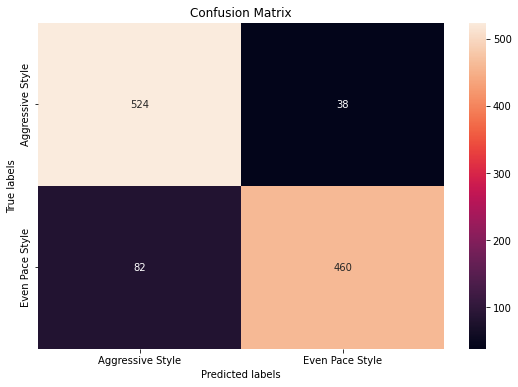

In [37]:
column_names = []
for x in one_hot.columns:
    column_names.append(x)

#creating confusion matrix as np array
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
#setting fig size
f = plt.figure(figsize=(20,6))
#plot
ax = f.add_subplot(121)

sn.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Aggressive Style', 'Even Pace Style']); ax.yaxis.set_ticklabels(['Aggressive Style', 'Even Pace Style']);
ax.tick_params(axis='both', which='major', labelsize=10)


### 4.1.c Creating a DF to display the difference between the prediction and the true label

In [38]:
std_score = model.score(X_test,y_test)

#Creating a DataFrame to display the accuracy of the DF by each feature
data = {'Altitude variation':[0],'Vehicle speed instantaneous':[0],'Vehicle speed average':[0],'Vehicle speed variance':[0],'Vehicle speed variation':[0],'Longitudinal acceleration':[0],'Engine load':[0],'Engine coolant temperature':[0],'Manifold absolute pressure':[0],'Engine rp m':[0],'Mass air flow':[0],'Intake air temperature':[0],'Vertical acceleration':[0],'Fuel consumption average':[0]}
ft_accuracy = pd.DataFrame(data)



In [39]:
#Creatinga pandas Df from numpy Array
X_test_Df = pd.DataFrame(X_test,columns=data)


for col in X_test_Df:
    #Make a copy of the df so that it is not altered
    copy = X_test_Df.copy()
    #Permutate the randomization of the values in the column
    copy[col] = np.random.permutation(copy[col])
    #In the feature accuracy df we will append the result of the standard accuracy score - standard accuracy score after randomizing that column
    #The result will be the difference in %
    ft_accuracy[col] = "{:.2%}".format(std_score - model.score(copy,y_test))
    #print(std_score,' - ', model.score(copy,y_test) )


print('Level of feature importance:')
ft_accuracy


Level of feature importance:


,Altitude variation,Vehicle speed instantaneous,Vehicle speed average,Vehicle speed variance,Vehicle speed variation,Longitudinal acceleration,Engine load,Engine coolant temperature,Manifold absolute pressure,Engine rp m,Mass air flow,Intake air temperature,Vertical acceleration,Fuel consumption average
0,1.99%,11.78%,4.62%,7.16%,0.63%,2.63%,2.26%,3.80%,2.17%,2.63%,0.82%,5.43%,2.90%,4.71%


## 4.2 SVM classifier algorithm

In [40]:
# SVM 

svm = SVC()
model = MultiOutputClassifier(svm, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy for SVM: ",accuracy)
"Done"

Accuracy for SVM:  0.8079710144927537


'Done'

## Hyper parameter Tuning
With the goal of setting the optimal parameters when running the model to achieve a faster and moore accurate model

In [41]:
param_grid = {'estimator__C': [0.1, 1, 10, 100, 1000],
              'estimator__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'estimator__kernel': ['rbf']}

### With GridSearch

In [42]:
#Estimator will be the model and param_grid will be the dictionary of parameters we set
svm_Grid = GridSearchCV(estimator = model, param_grid = param_grid, refit = True, verbose = 2)


In [43]:
#Now we will fit the Model
svm_Grid.fit(X_train, y_train)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END estimator__C=0.1, estimator__gamma=1, estimator__kernel=rbf; total time=   1.6s
[CV] END estimator__C=0.1, estimator__gamma=1, estimator__kernel=rbf; total time=   0.8s
[CV] END estimator__C=0.1, estimator__gamma=1, estimator__kernel=rbf; total time=   0.9s
[CV] END estimator__C=0.1, estimator__gamma=1, estimator__kernel=rbf; total time=   0.8s
[CV] END estimator__C=0.1, estimator__gamma=1, estimator__kernel=rbf; total time=   0.8s
[CV] END estimator__C=0.1, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.6s
[CV] END estimator__C=0.1, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.6s
[CV] END estimator__C=0.1, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.6s
[CV] END estimator__C=0.1, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.7s
[CV] END estimator__C=0.1, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.6s
[CV] END estimator__C=0.1, estimator__

[CV] END estimator__C=100, estimator__gamma=0.001, estimator__kernel=rbf; total time=   0.8s
[CV] END estimator__C=100, estimator__gamma=0.001, estimator__kernel=rbf; total time=   0.9s
[CV] END estimator__C=100, estimator__gamma=0.001, estimator__kernel=rbf; total time=   0.8s
[CV] END estimator__C=100, estimator__gamma=0.001, estimator__kernel=rbf; total time=   0.8s
[CV] END estimator__C=100, estimator__gamma=0.001, estimator__kernel=rbf; total time=   0.8s
[CV] END estimator__C=100, estimator__gamma=0.0001, estimator__kernel=rbf; total time=   0.8s
[CV] END estimator__C=100, estimator__gamma=0.0001, estimator__kernel=rbf; total time=   0.7s
[CV] END estimator__C=100, estimator__gamma=0.0001, estimator__kernel=rbf; total time=   0.7s
[CV] END estimator__C=100, estimator__gamma=0.0001, estimator__kernel=rbf; total time=   0.6s
[CV] END estimator__C=100, estimator__gamma=0.0001, estimator__kernel=rbf; total time=   0.6s
[CV] END estimator__C=1000, estimator__gamma=1, estimator__kernel

GridSearchCV(estimator=MultiOutputClassifier(estimator=SVC(), n_jobs=-1),
             param_grid={'estimator__C': [0.1, 1, 10, 100, 1000],
                         'estimator__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'estimator__kernel': ['rbf']},
             verbose=2)

In [44]:
svm_Grid.best_params_

{'estimator__C': 10, 'estimator__gamma': 1, 'estimator__kernel': 'rbf'}

1) Here we have the Train and Test results before adding the new parameters

In [45]:
print (f'Train Accuracy - : {model.score(X_train,y_train):.3f}')
print (f'Test Accuracy - : {model.score(X_test,y_test):.3f}')

Train Accuracy - : 0.833
Test Accuracy - : 0.808


2) Here we have the Train and Test results after adding the new parameters

In [46]:
print (f'Train Accuracy - : {svm_Grid.score(X_train,y_train):.3f}')
print (f'Test Accuracy - : {svm_Grid.score(X_test,y_test):.3f}')

Train Accuracy - : 0.998
Test Accuracy - : 0.870


Here we can see an overall improvement in the accuracy by applying these new parameters

### 4.2.b Evaluating feature Importance


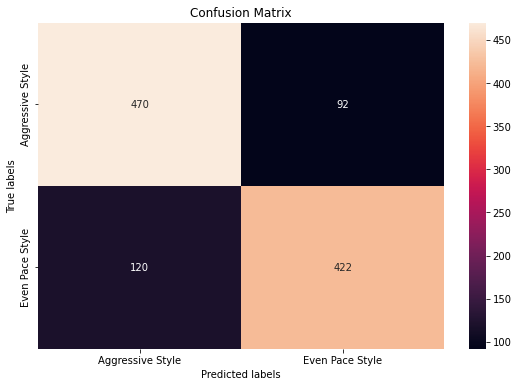

In [47]:

column_names = []
for x in one_hot.columns:
    column_names.append(x)

#creating confusion matrix as np array
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
#setting fig size
f = plt.figure(figsize=(20,6))
#plot
ax = f.add_subplot(121)

sn.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Aggressive Style', 'Even Pace Style']); ax.yaxis.set_ticklabels(['Aggressive Style', 'Even Pace Style']);
ax.tick_params(axis='both', which='major', labelsize=10)


### 4.2.c Creating a DF to display the difference between the prediction and the true label

In [48]:
datasvm = {'Altitude variation':[0],'Vehicle speed instantaneous':[0],'Vehicle speed average':[0],'Vehicle speed variance':[0],'Vehicle speed variation':[0],'Longitudinal acceleration':[0],'Engine load':[0],'Engine coolant temperature':[0],'Manifold absolute pressure':[0],'Engine rp m':[0],'Mass air flow':[0],'Intake air temperature':[0],'Vertical acceleration':[0],'Fuel consumption average':[0]}
ft_accuracy = pd.DataFrame(datasvm)

In [49]:
#Creatinga pandas Df from numpy Array
X_test_Df = pd.DataFrame(X_test,columns=data)


for col in X_test_Df:
    #Make a copy of the df so that it is not altered
    copy = X_test_Df.copy()
    #Permutate the randomization of the values in the column
    copy[col] = np.random.permutation(copy[col])
    #In the feature accuracy df we will append the result of the standard accuracy score - standard accuracy score after randomizing that column
    #The result will be the difference in %
    ft_accuracy[col] = "{:.2%}".format(std_score - model.score(copy,y_test))
    #print(std_score,' - ', model.score(copy,y_test) )


print('Level of feature importance:')
ft_accuracy

Level of feature importance:


,Altitude variation,Vehicle speed instantaneous,Vehicle speed average,Vehicle speed variance,Vehicle speed variation,Longitudinal acceleration,Engine load,Engine coolant temperature,Manifold absolute pressure,Engine rp m,Mass air flow,Intake air temperature,Vertical acceleration,Fuel consumption average
0,8.97%,25.00%,13.59%,12.41%,8.97%,11.59%,9.87%,9.60%,13.22%,12.59%,10.05%,11.41%,9.78%,9.42%
